In [2]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from keras.preprocessing import image

In [5]:
#Getting Images

Xtrain = []

destination_path = os.path.expanduser('mydata/train/')

for imagename in os.listdir('mydata/train/'):
    Xtrain.append(img_to_array(load_img(destination_path+imagename, target_size=(256, 256))))
Xtrain = np.array(Xtrain, dtype=float)

# Normalize data
Xtrain = 1.0/255*Xtrain

In [6]:
#CNN model

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

In [7]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model (500, 30)      
tensorboard = TensorBoard(log_dir="./output/beta_run")
trainedmodel = model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=5, steps_per_epoch=30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
 1/30 [>.............................] - ETA: 0s - loss: 0.1248 - accuracy: 0.4396WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 58s 2s/step - loss: 0.3506 - accuracy: 0.6040
Epoch 2/5
30/30 [==============================] - 60s 2s/step - loss: 0.0222 - accuracy: 0.7470
Epoch 3/5
30/30 [==============================] - 60s 2s/step - loss: 0.0183 - accuracy: 0.7673
Epoch 4/5
30/30 [==============================] - 60s 2s/step - loss: 0.0186 - accuracy: 0.7551
Epoch 5/5
30/30 [==============================] - 59s 2s/step - loss: 0.0183 - accuracy: 0.7724


In [8]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [9]:
# load json and create model

from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

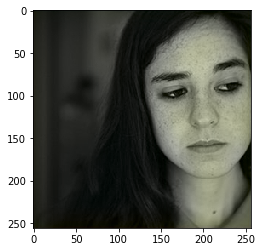

In [10]:
from pylab import *

img1_color = []

img1 = img_to_array(load_img('mydata/test/01.jpg'))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255 * img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = loaded_model.predict(img1_color)
output1 = output1 * 128

result = np.zeros((256,256,3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))